# 10/15/24: encoding phase plots
* As a reminder, 16 subjs across 29 session undergo watched an ~8 min film.
 
After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only)
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot)
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced)


In [154]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

### confirm number of subjects, neurons, trials

In [155]:
df = pd.read_pickle('neuron_by_trial_df.pkl')

df_encoding = df[df['stim_phase'] == 'encoding']
df_baseline = df[df['stim_phase'] == 'baseline']

df_enc_zeroFR = df_encoding[df_encoding['FR'] == 0] # 7 neurons trials get dropped
df_base_zeroFR = df_baseline[df_baseline['FR'] == 0] # 15 neurons trials get dropped

drop_enc_neur = df_enc_zeroFR['neuron'].unique()
drop_base_neur = df_base_zeroFR['neuron'].unique()
drop_zeroFR_neur = np.concatenate((drop_enc_neur, drop_base_neur))

print(f'neuron trials getting dropped due to having FR=0 in either encoding or baseline {drop_zeroFR_neur}')

# from df_encoding and df_baseline, drop the sessions with 0 FR
df_encoding = df_encoding[~df_encoding['neuron'].isin(drop_zeroFR_neur)]
df_baseline = df_baseline[~df_baseline['neuron'].isin(drop_zeroFR_neur)]

num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))
print(f'{num_subjs} subjects, {num_sess} sessions, {num_neurons} neurons')

num_subjs, num_sess, num_neurons = len(np.unique(df_baseline['subj'])), len(np.unique(df_baseline['sess'])), len(np.unique(df_baseline['neuron']))
print(f'{num_subjs} subjects, {num_sess} sessions, {num_neurons} neurons')

print(f'number of rows = {len(df_encoding)} = {len(df_baseline)}')

neuron trials getting dropped due to having FR=0 in either encoding or baseline ['P47CS_R1_19_4_1280_4' 'P47CS_R2_22_1_8375_4' 'P48CS_R2_58_3_6420_1'
 'P48CS_R2_62_2_2097_1' 'P51CS_R2_48_4_5337_7' 'P54CS_R2_31_1_2534_2'
 'P55CS_R1_49_2_5469_3' 'P43CS_R2_76_1_990_10' 'P47CS_R1_52_1_298_3'
 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1' 'P48CS_R2_58_3_6420_1'
 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1' 'P53CS_R1_37_1_3731_5'
 'P54CS_R1_70_2_5145_10' 'P54CS_R2_31_1_2534_2' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']
16 subjects, 29 sessions, 1438 neurons
16 subjects, 29 sessions, 1438 neurons
number of rows = 1438 = 1438


In [156]:
df_encoding.head()

subj      sess                neuron    region  start_time  stop_time  \
0    P41  P41CS_R1   P41CS_R1_21_1_679_4  amygdala         0.0  478.85512   
42   P41  P41CS_R1   P41CS_R1_38_1_613_5       ACC         0.0  478.85512   
84   P41  P41CS_R1  P41CS_R1_39_1_1359_5       ACC         0.0  478.85512   
126  P41  P41CS_R1  P41CS_R1_40_1_2816_5       ACC         0.0  478.85512   
168  P41  P41CS_R1  P41CS_R1_40_2_2821_5       ACC         0.0  478.85512   

            RT                                       trial_spikes  \
0    478.85512  [3.43207675, 4.39507675, 5.16801325, 5.2624507...   
42   478.85512  [0.2510465, 2.07970175, 4.70126325, 5.09220075...   
84   478.85512  [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...   
126  478.85512  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...   
168  478.85512  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...   

                                  trial_aligned_spikes  num_spikes        FR  \
0    [3.43207675, 4.39507675, 5.16801325, 5.2624507...         360  0.751793   
42   [0.2510465, 2.07970175, 4.70126325, 5.09220075...         278  0.580551   
84   [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...         949  1.981810   
126  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...        1820  3.800732   
168  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...         379  0.791471   

                                   trial_smooth_spikes  trial_smooth_FR  \
0    [2, 5, 8, 9, 5, 4, 1, 2, 3, 3, 4, 3, 4, 4, 4, ...         3.743697   
42   [3, 4, 3, 0, 2, 3, 2, 1, 0, 1, 2, 2, 2, 2, 3, ...         2.915966   
84   [5, 3, 2, 5, 11, 11, 8, 8, 7, 2, 10, 12, 11, 6...         9.852941   
126  [12, 16, 21, 14, 9, 7, 8, 26, 26, 25, 16, 15, ...        19.012605   
168  [4, 2, 7, 7, 4, 3, 2, 5, 6, 4, 3, 3, 3, 4, 6, ...         3.953782   

    stim_phase stimulus_file response_correct response_confidence  \
0     encoding      bd_movie              NaN                 NaN   
42    encoding      bd_movie              NaN                 NaN   
84    encoding      bd_movie              NaN                 NaN   
126   encoding      bd_movie              NaN                 NaN   
168   encoding      bd_movie              NaN                 NaN   

    actual_response  
0               NaN  
42              NaN  
84              NaN  
126             NaN  
168             NaN

In [157]:
df_baseline.head()

subj      sess                neuron    region  start_time  stop_time  \
1    P41  P41CS_R1   P41CS_R1_21_1_679_4  amygdala   478.85512  566.34646   
43   P41  P41CS_R1   P41CS_R1_38_1_613_5       ACC   478.85512  566.34646   
85   P41  P41CS_R1  P41CS_R1_39_1_1359_5       ACC   478.85512  566.34646   
127  P41  P41CS_R1  P41CS_R1_40_1_2816_5       ACC   478.85512  566.34646   
169  P41  P41CS_R1  P41CS_R1_40_2_2821_5       ACC   478.85512  566.34646   

           RT                                       trial_spikes  \
1    87.49134  [480.126667, 482.70775975, 483.49129, 488.6475...   
43   87.49134  [479.2808545, 481.4822285, 481.72213475, 482.2...   
85   87.49134  [479.251542, 479.3706045, 479.4167295, 479.490...   
127  87.49134  [478.893917, 478.91819825, 479.30832325, 479.9...   
169  87.49134  [480.52988475, 483.90244625, 485.74175775, 487...   

                                  trial_aligned_spikes  num_spikes        FR  \
1    [1.2715469999999982, 3.8526397499999803, 4.636...          50  0.571485   
43   [0.4257344999999759, 2.62710850000002, 2.86701...          61  0.697212   
85   [0.39642199999997274, 0.5154845000000137, 0.56...         197  2.251651   
127  [0.0387969999999882, 0.06307824999998957, 0.45...         252  2.880285   
169  [1.6747647500000085, 5.047326250000026, 6.8866...          59  0.674352   

                                   trial_smooth_spikes  trial_smooth_FR  \
1           [3, 2, 1, 1, 4, 6, 8, 4, 4, 2, 2, 2, 3, 3]         3.214286   
43          [5, 4, 3, 2, 2, 2, 3, 4, 5, 7, 4, 2, 3, 4]         3.571429   
85   [44, 30, 11, 10, 5, 5, 7, 8, 14, 10, 13, 6, 5, 7]        12.500000   
127  [16, 17, 15, 17, 17, 22, 20, 10, 9, 16, 16, 19...        15.142857   
169         [1, 2, 3, 3, 5, 6, 8, 6, 7, 5, 5, 4, 3, 1]         4.214286   

    stim_phase stimulus_file response_correct response_confidence  \
1     baseline            NA               NA                  NA   
43    baseline            NA               NA                  NA   
85    baseline            NA               NA                  NA   
127   baseline            NA               NA                  NA   
169   baseline            NA               NA                  NA   

    actual_response  
1                NA  
43               NA  
85               NA  
127              NA  
169              NA

In [158]:
scene_cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
scene_cuts_ts = scene_cuts_df['shot_start_t'].tolist()
scene_cuts_df.head()

scene_id  shot_start_fr  shot_start_t  shot_dur_t  location cut_type  \
0       1.0            1.0          0.00        4.72  backyard      cut   
1       1.0          119.0          4.72       10.28  backyard      cut   
2       1.0          376.0         15.00        1.72  backyard      cut   
3       1.0          419.0         16.72        2.36  backyard      cut   
4       1.0          478.0         19.08        2.64  backyard      cut   

   cut_dur_t  cut_dur_fr  
0        0.0           0  
1        0.0           0  
2        0.0           0  
3        0.0           0  
4        0.0           0

### normalize FR

In [161]:
for i in range(len(df_baseline)):
    print(len(df_baseline['trial_smooth_spikes'].iloc[i]), end=', ')

14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 

In [169]:
zscored_spikes_col = []

for row in range(len(df_encoding)):

    base_mean = np.mean(df_baseline['trial_smooth_spikes'].iloc[row])
    base_sd = np.std(df_baseline['trial_smooth_spikes'].iloc[row])
    
    zscore_smooth_spikes = (df_encoding['trial_smooth_spikes'].iloc[row] - base_mean) / base_sd
    zscored_spikes_col.append(zscore_smooth_spikes)

df_encoding['zscored_smooth_spikes'] = zscored_spikes_col
df_encoding['zscored_smooth_FR'] = df_encoding['zscored_smooth_spikes'].apply(lambda x: np.mean(x))

In [103]:
# def z_score(data):
#     return (data - np.mean(data)) / np.std(data)

# df_encoding['zscored_smooth_spikes'] = df_encoding['trial_smooth_spikes'].apply(lambda x: z_score(np.array(x)))
# df_encoding['zscored_smooth_FR'] = df_encoding['zscored_smooth_spikes'].apply(lambda x: np.mean(x))

1438 trials


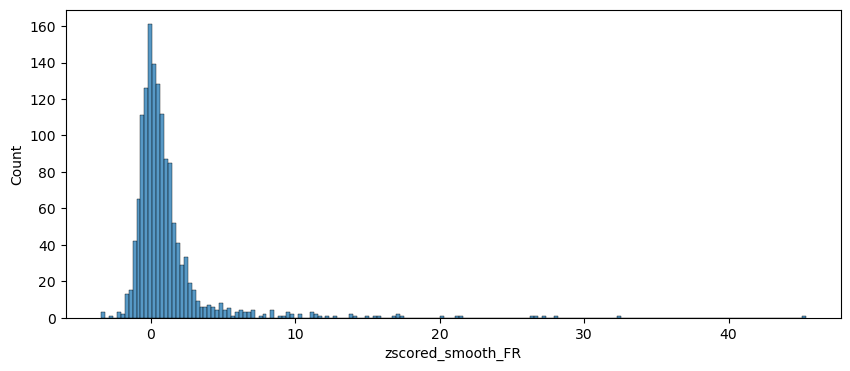

In [170]:
print(f'{len(df_encoding)} trials')

plt.figure(figsize=(10,4))
sns.histplot(df_encoding['zscored_smooth_FR'])
plt.show()

### smooth FRs of individual neurons from different regions, across sessions

Significant pro-
portions of cells were event selective in the vmPFC (10/175, p =  0.005, permutation test) and preSMA (20/299,  p <  0.001) but not in the amygdala (15/479, p =  0.081), ACC (7/236, p =  0.224), and hippocampus (8/261, p = 0.199;  Fig. 7a,b show examples).

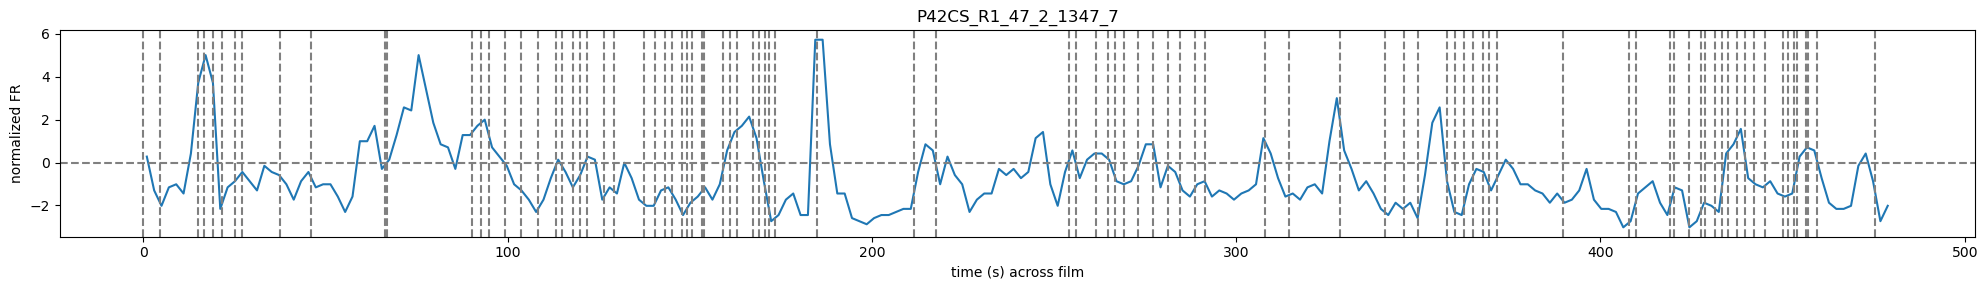

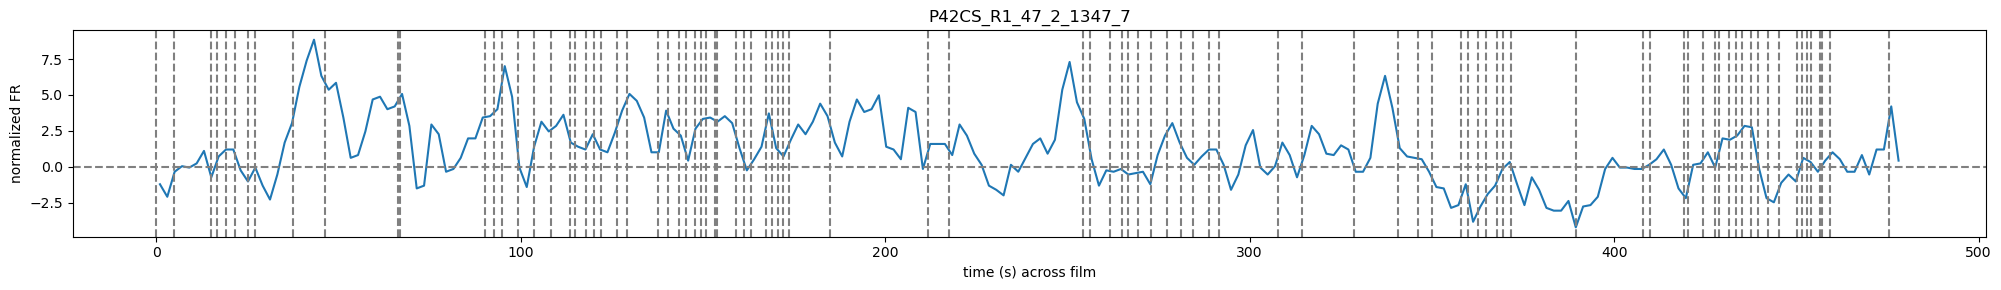

In [200]:
for neuron in ['P42CS_R1_47_2_1347_7', 'P47CS_R1_78_1_2233_10']:

    neuron_df = df_encoding[df_encoding['neuron'] == neuron]

    num_bins = len(neuron_df['zscored_smooth_spikes'].iloc[0])  # Get the length of the first spike array
    x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)

    plt.figure(figsize=(20, 3))
    plt.plot(x_time_points, neuron_df['zscored_smooth_spikes'].iloc[0], label=neuron)

    # make vertical lines at each scene cut
    for cut in scene_cuts_ts:
        plt.axvline(x=cut, color='grey', linestyle='--')

    plt.xlabel('time (s) across film')
    plt.ylabel('normalized FR')
    plt.title('P42CS_R1_47_2_1347_7')
    plt.axhline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.show()


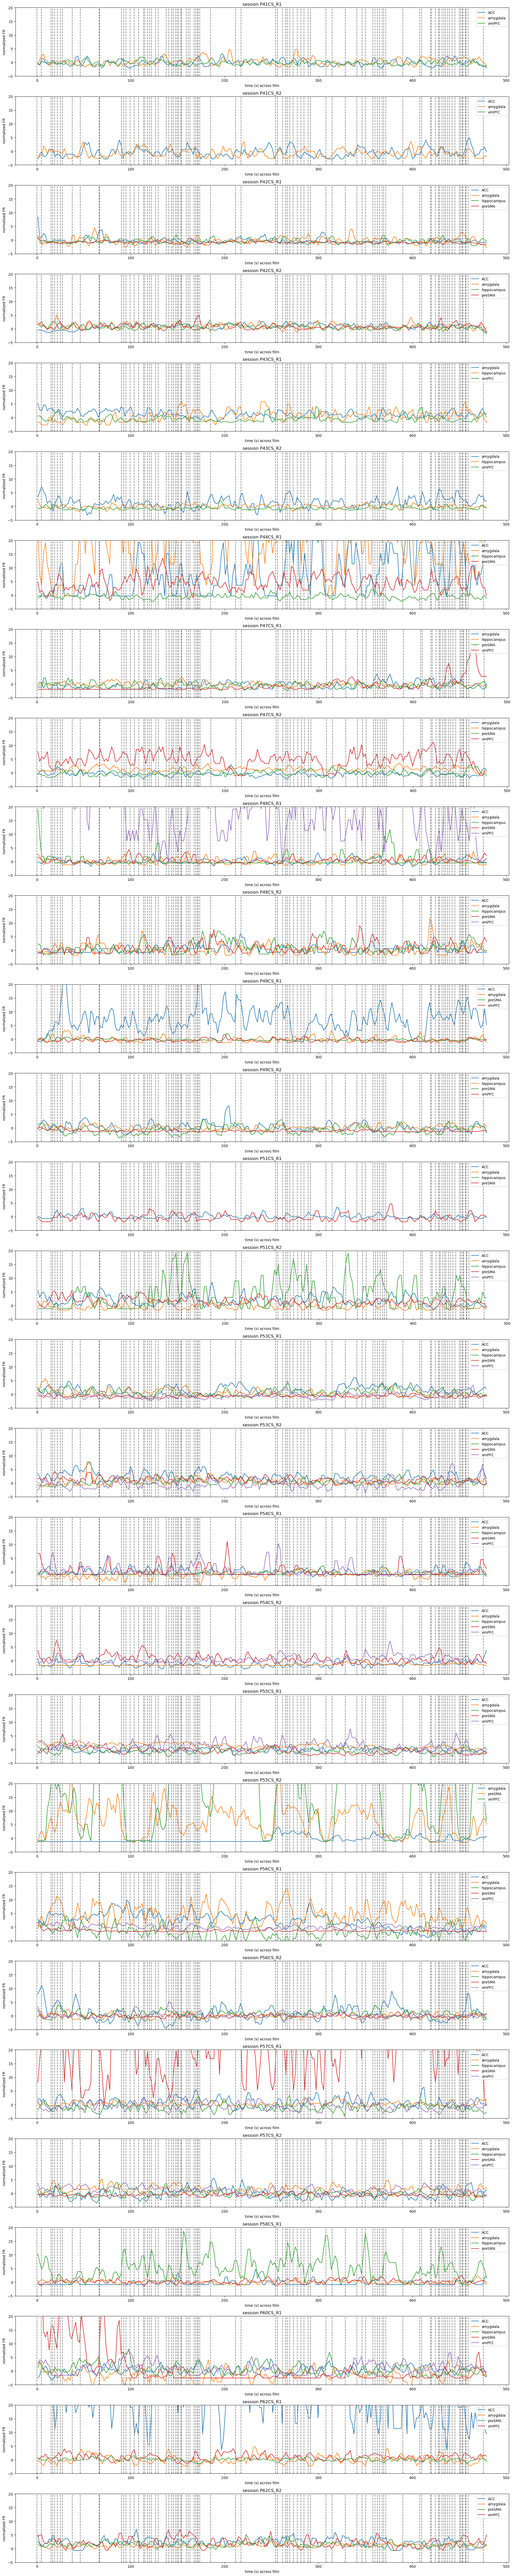

In [196]:
sess_num = 0  # specify how many sessions to plot

fig, axs = plt.subplots(29, 1, figsize=(20, 100))

for session, session_df in df_encoding.groupby('sess'):

    # if not 'vmPFC' in session_df['region'].values:
    #     continue

    for region, region_df in session_df.groupby('region'):

        if True: #region == 'vmPFC':
            neuron_groups = list(region_df.groupby('neuron'))

            # pick random neuron from each region
            rand_neuron_id = np.random.randint(len(neuron_groups))
            neuron, neuron_df = neuron_groups[rand_neuron_id]

            # convert x-axis from bins to time
            num_bins = len(neuron_df['zscored_smooth_spikes'].iloc[0])
            x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)

            axs[sess_num].plot(x_time_points, neuron_df['zscored_smooth_spikes'].iloc[0], label=region)

    # make vertical lines at each scene cut
    for cut in scene_cuts_ts:
        axs[sess_num].axvline(x=cut, color='grey', linestyle='--')

    axs[sess_num].set_title(f'session {session}')
    axs[sess_num].set_xlabel('time (s) across film')
    axs[sess_num].set_ylabel('normalized FR')
    axs[sess_num].set_ylim(-5, 20)
    axs[sess_num].legend(loc='upper right')
    
    sess_num += 1

plt.tight_layout()  
plt.show()


### trial-avged FRs by correctness

In [30]:
# print(df_recognition.groupby(['region', 'response_correct']).size())

# trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='response_correct')
# plt.title('Trial-avged neuron FR')
# plt.show()
